In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tifffile as tf
import pycellsort.cellsort_PCA as PCA
import pycellsort.cellsort_ICA as ICA
import os
import numpy as np
PCA.ENABLE_onTime_daul_PCA = True
from matplotlib import pyplot as plt


In [3]:
import logging
path = "data_1p-1.tif"
nPCs = 150
outputdir = 'mmc2temp'
mu = 0.5

data = tf.imread(path)

logger = logging.getLogger()
logger.setLevel(logging.INFO)
log_file = os.path.join(outputdir, 'log.txt') # TODO 修改成合适的非重复名称
file_handler = logging.FileHandler(log_file)
file_handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

meanImage = data.mean(axis=0)

In [105]:
## PCA 
## TODO check why dual PCA failed
PCA.ENABLE_onTime_daul_PCA = False
mixedsig, mixedfilter, eigenvalues, covtrace, temporal_mean, spacial_mean =PCA.cellsortPCA(data,nPCs,outputdir=outputdir,logger=logger)
# PCA.viewPCAResults(mixedfilter,outputdir+"/PCA_PC")


Saving PCA results to output directory not yet implemented


In [106]:
## numberic quality check for PCA
c_fil = mixedfilter @ mixedfilter.T
print(np.sum(np.abs(c_fil - np.eye(c_fil.shape[0]))))

c_sig = mixedsig @ mixedsig.T
print(np.sum(np.abs(c_sig-np.eye(c_sig.shape[0]))))

1.6981929780525608e-12
4.844692191296736e-12


In [ ]:
## show
PCA.viewPCAResults(mixedfilter,outputdir+"/PCA_PC",packN=49)

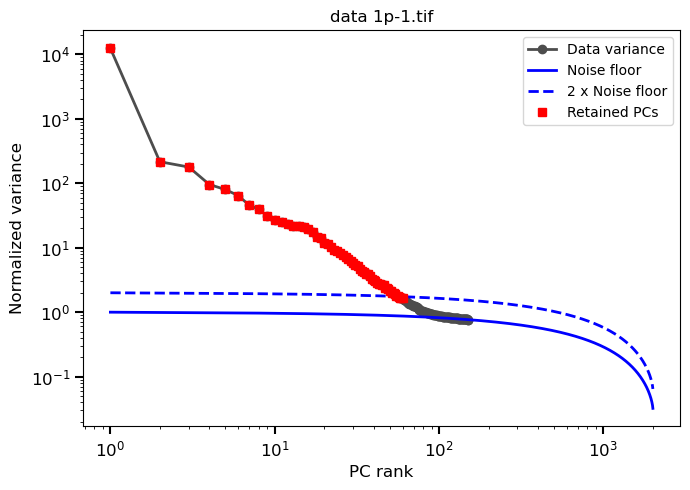

In [ ]:
## PCA select
PC_use  = list(range(0,60))
_,_ = PCA.plot_pc_spectrum(path, eigenvalues, PC_use,show=True)

In [107]:
## ICA
ICA.ICA_SK = False
ica_sig, ica_filters, ica_A = ICA.cellsortICA(mixedsig,mixedfilter,eigenvalues,mu=0.5,num_IC=50,termtol=1e-12,maxrounds=500,PC_use=PC_use,logger=logger)



In [109]:
## ICA quality check
corr_ica_filters = ica_filters @ ica_filters.T
print(np.sum(np.abs(corr_ica_filters - np.eye(corr_ica_filters.shape[0]))))

corr_ica_sig = ica_sig @ ica_sig.T
print(np.sum(np.abs(corr_ica_sig - np.eye(corr_ica_sig.shape[0]))))

6.95067782626943e-13
1.4309320702898375e-12


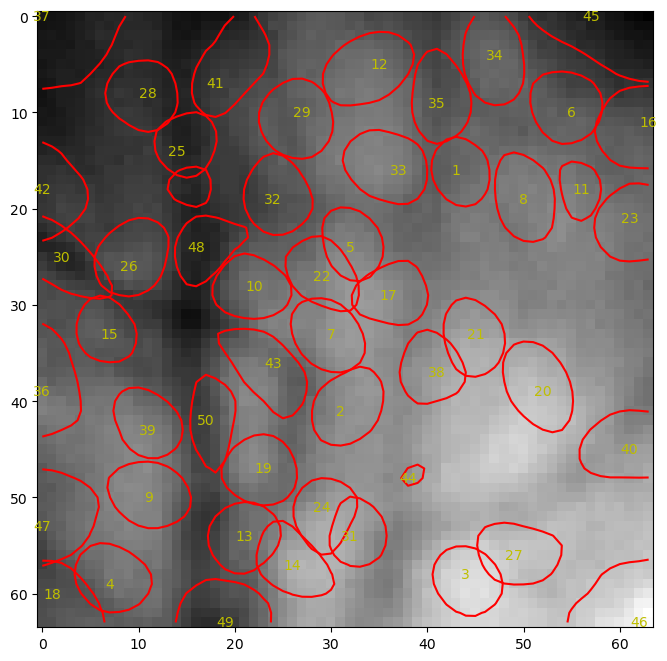

In [ ]:
## show
fig = ICA.ICAshow(ica_filters.reshape(-1,64,64), meanImage,(8,8),5,cmap='gray')
fig.savefig(outputdir + '/ica_filters.png',dpi=300)

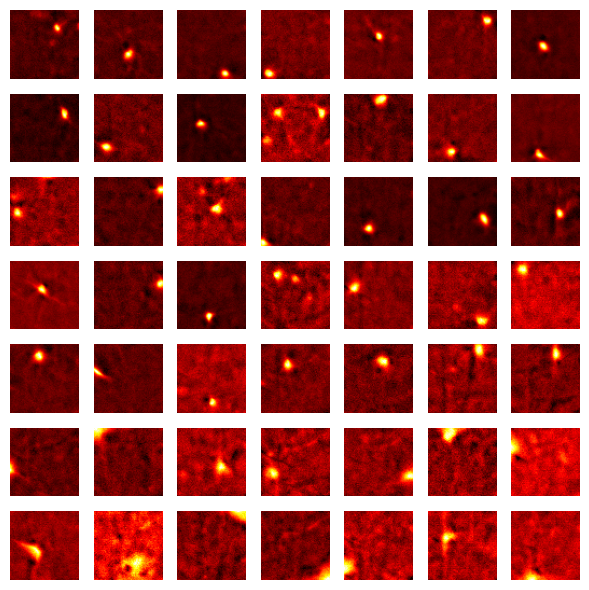

In [86]:
PCA.viewPCAResults(ica_filters.reshape(-1,64,64),outputdir+"/ICA_PC",packN=49)

In [ ]:
## segment
segments, segment_labels, seg_centroids =ICA.cellsortSegment(ica_filters.reshape(-1,64,64),smwidth=1, thresh=3.2, areaLimits=(50,400))
print(segment_labels)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43]


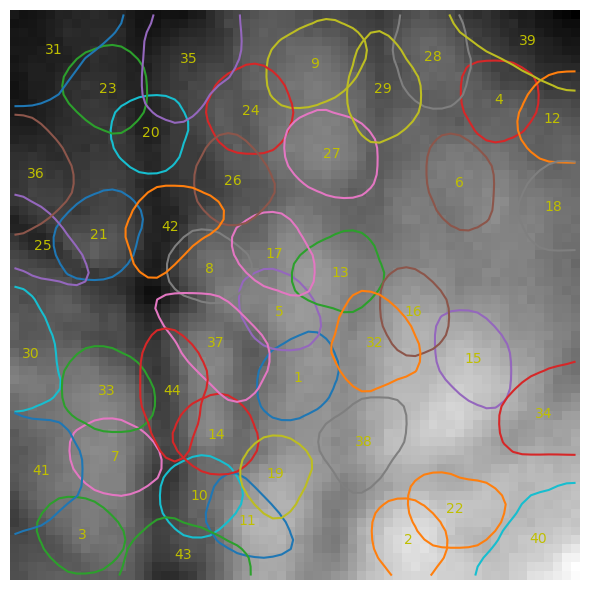

In [ ]:
## shows
fig2 = ICA.cellsortSegmentPlot(segments,seg_centroids,segment_labels, meanImage,cmap='gray')
fig2.savefig(outputdir + '/ica_segments.png',dpi=300)